# Preguntas y respuestas

## Explorar los datos mediante consultas SQL y responder las preguntas planteadas sobre calidad y transformación de los datos:

1. ¿Cuáles fueron los 5 productos más vendidos (por cantidad total), y cuál fue el vendedor que más unidades vendió de cada uno? Una vez obtenga los resultados, en el análisis responde: ¿Hay algún vendedor que aparece más de una vez como el que más vendió un producto? ¿Algunos de estos vendedores representan más del 10% de la ventas de este producto?

2.Entre los 5 productos más vendidos, ¿cuántos clientes únicos compraron cada uno y qué proporción representa sobre el total de clientes? Analiza si ese porcentaje sugiere que el producto fue ampliamente adoptado entre los clientes o si, por el contrario, fue comprado por un grupo reducido que generó un volumen alto de ventas. Compara los porcentajes entre productos e identifica si alguno de ellos depende más de un segmento específico de clientes

**Solución 1a** (¿Cuáles fueron los 5 productos más vendidos (por cantidad total))

```sql
SELECT 
    p.productID AS product_id,
    p.productName AS product_name,
    SUM(s.quantity) AS total_quantity
FROM sales s
JOIN products p ON s.productID = p.productID
GROUP BY p.productID, p.productName
ORDER BY total_quantity DESC
LIMIT 5;
```

**Resultado**:
![alt text](assets/image-1-a.png)
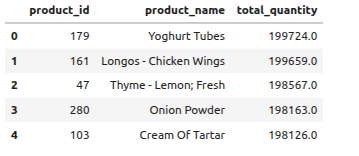
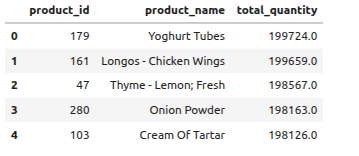


**Solución 1b** ¿Cuáles fueron los 5 productos más vendidos (por cantidad total), y cuál fue el vendedor que más unidades vendió de cada uno?

```sql
WITH top_products AS (
    SELECT 
        p.productID AS product_id,
        p.productName AS product_name,
        SUM(s.quantity) AS total_quantity
    FROM products p
    JOIN sales s ON p.productID = s.productID
    GROUP BY p.productID, p.productName
    ORDER BY total_quantity DESC
    LIMIT 5
),
seller_sales AS (
    SELECT 
        tp.product_id,
        tp.product_name,
        tp.total_quantity AS total_sold,
        s.salesPersonID AS seller_id,
        SUM(s.quantity) AS seller_quantity
    FROM top_products tp
    JOIN sales s ON tp.product_id = s.productID
    GROUP BY tp.product_id, tp.product_name, s.salesPersonID
),
ranked_sellers AS (
    SELECT 
        *,
        RANK() OVER (PARTITION BY product_id ORDER BY seller_quantity DESC) AS seller_rank
    FROM seller_sales
)
SELECT 
    rs.product_id,
    rs.product_name,
    rs.seller_id,
    rs.total_sold,
    CONCAT( e.FirstName ,' ', e.LastName) AS seller_name,
    rs.seller_quantity
FROM ranked_sellers rs
JOIN employees e ON rs.seller_id = e.employeeID
WHERE seller_rank = 1
ORDER BY seller_quantity DESC;
```

**Resultado**:  

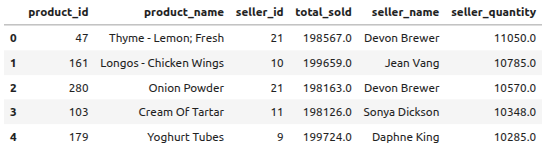

**Solución 1c** ¿Hay algún vendedor que aparece más de una vez como el que más vendió un producto? ¿Algunos de estos vendedores representan más del 10% de la ventas de este producto?

**Respuesta**  Devon Brewer aparece dos veces (como el mejor vendedor para *Thyme - Lemon; Fresh* y *Onion Powder*). Ningún vendedor representa maás del 10% de ventas sobre el total de cada producto ; en líneas generales rondan un 5% del total de ventas de cada producto.

=========================================================================================================================================


**Solución 2a** (Entre los 5 productos más vendidos, ¿cuántos clientes únicos compraron cada uno y qué proporción representa sobre el total de clientes?)

```sql
WITH top_products AS (
    SELECT 
        p.productID AS product_id,  
        p.productName AS product_name,
        SUM(s.quantity) AS total_quantity
    FROM products p
    JOIN sales s ON p.productID = s.productID
    GROUP BY p.productID, p.productName
    ORDER BY total_quantity DESC
    LIMIT 5
),
customer_counts AS (
    SELECT
        tp.product_id,
        COUNT(DISTINCT s.customerID) AS unique_customers
    FROM top_products tp
    JOIN sales s ON tp.product_id = s.productID
    GROUP BY tp.product_id
),
total_customers AS (
    SELECT COUNT(DISTINCT customerID) AS total_customers
    FROM sales
)
SELECT
    cc.product_id,
    tp.product_name,
    cc.unique_customers,
    tc.total_customers,
    ROUND((cc.unique_customers/ tc.total_customers) * 100, 2) AS proportion_percentage
FROM customer_counts cc
JOIN top_products tp ON cc.product_id = tp.product_id
JOIN total_customers tc ON true
ORDER BY cc.unique_customers DESC;
```

**Resultado**:  

![table-2-a](assets/image-2-a.png)


**Solución 2b** (A qué categorías pertenecen los 5 productos más vendidos y qué proporción representan dentro del total de unidades vendidas de su categoría? )

```sql
WITH top_sales AS (
    SELECT 
        p.productID AS product_id,
        p.productName AS product_name,
        p.categoryID AS category_id,
        c.categoryName AS category_name,
        SUM(s.quantity) AS total_quantity
    FROM sales s
    JOIN products p ON s.productID = p.productID
    JOIN categories c ON p.categoryID = c.categoryID
    GROUP BY p.productID, p.productName, p.categoryID, c.categoryName
    ORDER BY total_quantity DESC
    LIMIT 5
),
category_totals AS (
    SELECT 
        ts.category_id,
        SUM(s.quantity) AS total_category_quantity
    FROM sales s
    JOIN products p ON s.productID = p.productID
    JOIN top_sales ts ON ts.category_id = p.categoryID
    GROUP BY ts.category_id
)
SELECT 
    ts.product_id,
    ts.product_name,
    ts.category_name,
    ts.total_quantity,
    ct.total_category_quantity,
    ROUND(100.0 * ts.total_quantity / ct.total_category_quantity, 2) AS category_percentage
FROM top_sales ts
JOIN category_totals ct ON ts.category_id = ct.category_id
ORDER BY category_percentage DESC;
```

**Resultado**:  

![table-2-b](assets/image-2-b.png)


**Solución 2c** (¿Cuáles son los 10 productos con mayor cantidad de unidades vendidas en todo el catálogo y cuál es su posición dentro de su propia categoría? Utiliza funciones de ventana para identificar el ranking de cada producto en su categoría. Luego, analiza si estos productos son también los líderes dentro de sus categorías o si compiten estrechamente con otros productos de alto rendimiento. ¿Qué observas sobre la concentración de ventas dentro de algunas categorías?)


```sql
SELECT 
    p.productID AS product_id,
    p.productName AS product_name,
    SUM(s.quantity) AS total_quantity
FROM sales s
JOIN products p ON s.productID = p.productID
GROUP BY p.productID, p.productName
ORDER BY total_quantity DESC
LIMIT 5;
```

**Resultado**:  

![table-2-c](assets/image-2-c.png)

**Análisis** En las categorías Snails, Meat y Poultry, aparecen tanto el primer como el segundo producto en el ranking dentro del top 10 de ventas. Sin embargo, la diferencia en el volumen de ventas entre el primero y el segundo lugar es pequeña, lo que indica una competencia marcada dentro de estas categorías.

En cambio, en las otras categorías representadas (Seafood, Beverages, Dairy y Produce), solo aparece un producto por categoría, lo que sugiere una alta concentración de ventas en un único producto dentro de cada una.

En resumen, aunque se observa cierta concentración de ventas en productos específicos de algunas categorías, los seis primeros productos más vendidos provienen de distintas categorías, lo que sugiere una distribución relativamente equilibrada en cuanto a categorías representadas. Sin embargo, la diferencia en el total de ventas entre el primer y el décimo producto es pequeña (menor  dos mil unidades, es decir menor al 1%), lo que indica una concentración general en pocos productos de rendimiento muy similar.
